In [57]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1
from tensorflow.keras.callbacks import Callback
import numpy as np
import math
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [58]:
import sympy
from itertools import accumulate
import time
import pickle as pkl

In [59]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
device_name

Num GPUs Available:  0


''

In [60]:
file = open('conditional_data.pkl','rb')
cond_data = pkl.load(file)
print(cond_data.shape)

(64, 1000, 5)


In [61]:
global input_dim
# global regularise_weights

size = 1000
batch_size = 200

l0_reg = tf.Variable(initial_value=0, trainable=False, dtype=tf.float32)
l1_reg = tf.Variable(initial_value=0, trainable=False, dtype=tf.float32)

In [62]:
def threshold_matrix(matrix, thresh):
  with tf.device(device_name):
    mask = tf.abs(matrix) > thresh
    new_mat = tf.multiply(tf.cast(mask,dtype=tf.float32),matrix)
    return new_mat

In [63]:
@tf.function
def l1_regularizer(weights):
  with tf.device(device_name):
    loss = l1_reg*tf.reduce_sum(tf.abs(weights))
    return loss

In [64]:
class dense_layer(layers.Layer):
  def __init__(self, w0, d, v, begin=False, last=False):
    super().__init__()
    w_init = tf.random_uniform_initializer(minval = -w0, maxval = w0, seed = 3)
    if last:
      self.layer = layers.Dense(d, input_shape = (3*v,), kernel_initializer=w_init) # kernel_regularizer=l1_regularizer, bias_regularizer=l1_regularizer)
    elif begin:
      self.layer = layers.Dense(3*v, input_shape = (input_dim,), kernel_initializer=w_init) # kernel_regularizer=l1_regularizer, bias_regularizer=l1_regularizer)
    else:
      self.layer = layers.Dense(3*v, input_shape = (3*v,), kernel_initializer=w_init) # kernel_regularizer=l1_regularizer, bias_regularizer=l1_regularizer)

  def call(self, input):
    z = self.layer(input)
    return z

In [65]:
class dense_layer_no_id(layers.Layer):
  def __init__(self, w0, d, v, begin=False, last=False):
    super().__init__()
    w_init = tf.random_uniform_initializer(minval = -w0, maxval = w0, seed = 3)
    if last:
      self.layer = layers.Dense(d, input_shape = (2*v,), kernel_initializer=w_init) # kernel_regularizer=l1_regularizer, bias_regularizer=l1_regularizer)
    elif begin:
      self.layer = layers.Dense(2*v, input_shape = (input_dim,), kernel_initializer=w_init) # kernel_regularizer=l1_regularizer, bias_regularizer=l1_regularizer)
    else:
      self.layer = layers.Dense(2*v, input_shape = (2*v,), kernel_initializer=w_init) # kernel_regularizer=l1_regularizer, bias_regularizer=l1_regularizer)

  def call(self, input):
    z = self.layer(input)
    return z

In [67]:
ops = {#'id' : tf.identity,
       'sin' : tf.sin,
       'cos' : tf.cos }

# sympy_ops = [sympy.Id, sympy.sin, sympy.cos]
sympy_ops = [sympy.sin, sympy.cos]

In [68]:
def eql_func(var):
  with tf.device(device_name):
    z = var[0]
    v = var[1]
    units = tf.split(z,num_or_size_splits=[v,v,v],axis=1)
    outputs = []
    i = 0
    for _,operator in ops.items():
      inputs = tf.split(units[i],[v]*1,axis=1)
      outputs.append(operator(*inputs))
      i = i+1
    y = tf.concat(outputs,axis=1)
    return y

In [69]:
def eql_func_no_id(var):
  with tf.device(device_name):
    z = var[0]
    v = var[1]
    units = tf.split(z,num_or_size_splits=[v,v],axis=1)
    outputs = []
    i = 0
    for _,operator in ops.items():
      inputs = tf.split(units[i],[v]*1,axis=1)
      outputs.append(operator(*inputs))
      i = i+1
    y = tf.concat(outputs,axis=1)
    return y

In [107]:
# # Dataset
# tf.random.set_seed(3)
# x_data = tf.random.uniform(shape=[size,5],minval=-1,maxval=1,seed=10)

# ## Hamiltonian eqn
# y_data = tf.math.cos(x_data[:,0]-x_data[:,1]) + tf.math.cos(x_data[:,0]-x_data[:,2]) \
#           + tf.math.cos(x_data[:,0]-x_data[:,3]) + tf.math.cos(x_data[:,0]-x_data[:,4])

# np.random.seed(3)
# train_split = 0.8
# idx = np.arange(size)
# np.random.shuffle(idx)
# train_idx = idx[:int(train_split*size)]
# val_idx = idx[int(train_split*size):]

# x_train = tf.gather(x_data, train_idx)
# x_val = tf.gather(x_data, val_idx)
# y_train = tf.gather(y_data, train_idx)
# y_val = tf.gather(y_data, val_idx)

# print(x_train.get_shape(), y_train.get_shape())
# print(x_val.get_shape(), y_val.get_shape())

(800, 5) (800,)
(200, 5) (200,)


In [70]:
# Conditional Dataset ##################################################
pos = 10
x_data = cond_data[pos]
print(x_data[0])
x_data = x_data*(2*np.pi) # scaled [0,1) to [0,2pi)
print(x_data[0])

np.random.seed(3)
train_split = 0.8
idx = np.arange(size)
np.random.shuffle(idx)
train_idx = idx[:int(train_split*size)]
val_idx = idx[int(train_split*size):]

x_train = tf.gather(x_data, train_idx)
x_val = tf.gather(x_data, val_idx)

print(x_train.get_shape(), x_val.get_shape())

[0.0668435  0.2736027  0.26882994 0.3134225  0.32157192]
[0.41999012 1.71909646 1.68910831 1.96929167 2.02049597]
(800, 5) (200, 5)


In [107]:
x_val_new = tf.gather(x_data, val_idx)
x_val_new.get_shape()

TensorShape([200, 5])

In [71]:
x_train = x_train[:,0]
x_val = x_val[:,0]
print(x_train.get_shape(), x_val.get_shape())

(800,) (200,)


In [72]:
train_data = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices(x_val).batch(batch_size)

In [83]:
#input params
reg_ph = [0.0,0.45]
epoch_factor = 2000
beta1 = 0.4
l0_thresh = 0.05
reg_scale = 1e-3
wt_init_param = 1.0
L = 2
out_dim = 1

w0 = wt_init_param/math.sqrt(1 + L)
reg_start = math.floor((L-1)*epoch_factor*reg_ph[0])
reg_end = math.floor((L-1)*epoch_factor*reg_ph[1])
print(f'w0 : {w0}')
print(f'reg_start : {reg_start}')
print(f'reg_end : {reg_end}')

w0 : 0.5773502691896258
reg_start : 0
reg_end : 900


In [84]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=beta1, epsilon=1e-4)
# loss_func = tf.keras.losses.MeanSquaredError()

In [ ]:
#### Using Keras API ##############################

class myCallback(Callback):
  def __init__(self):
    super().__init__()
  def on_epoch_begin(self, epoch, logs={}):
    if epoch>=reg_start and epoch<=reg_end:
      l1_reg.assign(tf.cast(reg_scale, dtype=tf.float32))
    if epoch>reg_end:
      # regularise_weights = True
      l1_reg.assign(tf.cast(0, dtype=tf.float32))
      l0_reg.assign(tf.cast(l0_thresh, dtype=tf.float32))

call_back = myCallback()

input_dim = 5
d = 1
v = 10
T = (L-1)*20

begin = True
input = tf.keras.Input(shape=(input_dim,), name= 'model_input')
y = input
for i in range(L-1):
  z = dense_layer(w0, d, v, begin = begin)(y)
  y = layers.Lambda(eql_func, name = f'func_layer_{i}')([z,v])
  begin = False
output = dense_layer(w0, d, v, last=True)(y)

model = tf.keras.Model(inputs = input, outputs = output, name = 'eql_div')
model.compile(optimizer, loss = loss_func) #, run_eagerly=True)

model.summary()
model.fit(x_train, y_train, epochs=T, batch_size=20, validation_split=0.2, callbacks=[call_back])

In [ ]:
saved_weight = False

if saved_weight:
    model.built = True
    model.load_weights('eql_bolt_L3.h5')

In [ ]:
#save model
model.save_weights('eql_bolt_L3_reg.h5')

In [75]:
#### Method 2 ############################################

input_dim = 5
d = 1
v = 4
T = (L-1)*1000
temp = 0.5

begin = True
d_layers = []
for i in range(L-1):
  d_layers.append(dense_layer(w0, d, v, begin = begin))
  begin = False
d_layers.append(dense_layer(w0, d, v, last=True))

input = tf.keras.Input(shape=(input_dim,), name= 'model_input')
y = input
for i in range(L-1):
  z = d_layers[i](y)
  y = layers.Lambda(eql_func, name = f'func_layer_{i}')([z,v])
output = d_layers[-1](y)

model = tf.keras.Model(inputs = input, outputs = output, name = 'eql_div')

In [92]:
### Method 3 (No Identity Operation) ######################################
input_dim = 1
d = 1
v = 4
T = (L-1)*5000
temp = 0.5

begin = True
d_layers = []
for i in range(L-1):
  d_layers.append(dense_layer_no_id(w0, d, v, begin = begin))
  begin = False
d_layers.append(dense_layer_no_id(w0, d, v, last=True))

input = tf.keras.Input(shape=(input_dim,), name= 'model_input')
y = input
for i in range(L-1):
  z = d_layers[i](y)
  y = layers.Lambda(eql_func_no_id, name = f'func_layer_{i}')([z,v])
output = d_layers[-1](y)

model = tf.keras.Model(inputs = input, outputs = output, name = 'eql_div')

In [93]:
def reassign_values(e):
  if e<reg_start:
    l1_reg.assign(tf.cast(0, dtype=tf.float32))
    l0_reg.assign(tf.cast(0, dtype=tf.float32))
  elif e>=reg_start and e<=reg_end:
    l1_reg.assign(tf.cast(reg_scale, dtype=tf.float32))
  elif e>reg_end:
    l1_reg.assign(tf.cast(0, dtype=tf.float32))
    l0_reg.assign(tf.cast(l0_thresh, dtype=tf.float32))

In [94]:
def l1_loss(model):
    loss = 0.
    for wgt in model.trainable_weights:
        loss += l1_reg*tf.reduce_sum(tf.abs(wgt)) 
    return loss

In [95]:
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        output = model(x, training=True)
        # print(output)
        loss_value = -tf.reduce_mean(output) + l1_loss(model)
        #print(f"l1_model: {l1_loss(model).shape}")
        # print(f"loss_value:{loss_value}")
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

@tf.function
def val_step(x):
    output = model(x, training=False)
    loss_value = -tf.reduce_mean(output)
    return loss_value

In [96]:
epoch_loss = []

for e in range(T):
  train_losses = []
  val_losses = []

  reassign_values(e)
  for step, x_tr_batch in enumerate(train_data):
    loss = train_step(x_tr_batch)
    train_losses.append(loss)
  
  for step, x_v_batch in enumerate(val_data):
    loss = val_step(x_v_batch)
    val_losses.append(loss)

  #l0 regularisation
  for i in range(len(d_layers)):
    kernel, bias = d_layers[i].layer.get_weights()
    kernel1 = threshold_matrix(kernel, l0_reg)
    bias1 = threshold_matrix(bias, l0_reg)
    d_layers[i].layer.set_weights([kernel1, bias1])

  train_loss = np.mean(np.array(train_losses))
  val_loss = np.mean(np.array(val_losses))
  epoch_loss.append([train_loss, val_loss])
  
  if e%10 == 0:
    print(f'Epoch {e}/{T}      train_loss = {train_loss}     val_loss = {val_loss}')

Epoch 0/5000      train_loss = 0.7129541039466858     val_loss = 0.5741627812385559
Epoch 10/5000      train_loss = 0.5671870112419128     val_loss = 0.44751253724098206
Epoch 20/5000      train_loss = 0.4942284822463989     val_loss = 0.3755955398082733
Epoch 30/5000      train_loss = 0.43948325514793396     val_loss = 0.3212478756904602
Epoch 40/5000      train_loss = 0.3941501975059509     val_loss = 0.2762227952480316
Epoch 50/5000      train_loss = 0.35476264357566833     val_loss = 0.23715262115001678
Epoch 60/5000      train_loss = 0.31953778862953186     val_loss = 0.20227622985839844
Epoch 70/5000      train_loss = 0.28741854429244995     val_loss = 0.17053991556167603
Epoch 80/5000      train_loss = 0.25771811604499817     val_loss = 0.14125512540340424
Epoch 90/5000      train_loss = 0.2299618124961853     val_loss = 0.11394447088241577
Epoch 100/5000      train_loss = 0.2038062959909439     val_loss = 0.08826160430908203
Epoch 110/5000      train_loss = 0.17899425327777863 

2023-07-10 16:21:53.538986: W tensorflow/core/data/root_dataset.cc:273] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch 1300/5000      train_loss = -0.9540930986404419     val_loss = -1.0420756340026855
Epoch 1310/5000      train_loss = -0.9576504826545715     val_loss = -1.0459572076797485
Epoch 1320/5000      train_loss = -0.9612074494361877     val_loss = -1.0498385429382324
Epoch 1330/5000      train_loss = -0.9647645950317383     val_loss = -1.0537197589874268
Epoch 1340/5000      train_loss = -0.968320369720459     val_loss = -1.057599663734436
Epoch 1350/5000      train_loss = -0.9718757271766663     val_loss = -1.0614789724349976
Epoch 1360/5000      train_loss = -0.9754307270050049     val_loss = -1.0653579235076904
Epoch 1370/5000      train_loss = -0.9789853096008301     val_loss = -1.0692366361618042
Epoch 1380/5000      train_loss = -0.9825395345687866     val_loss = -1.0731148719787598
Epoch 1390/5000      train_loss = -0.9860934615135193     val_loss = -1.0769927501678467
Epoch 1400/5000      train_loss = -0.9896466732025146     val_loss = -1.0808699131011963
Epoch 1410/5000      tr

In [97]:
epoch_loss = np.array(epoch_loss)

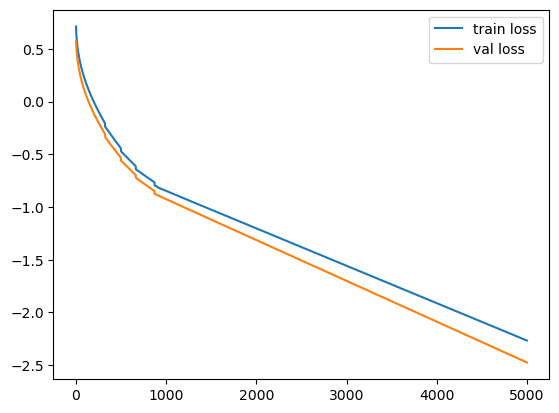

In [98]:
def plot_results(losses):
    train_loss = losses[:,0]
    val_loss = losses[:,1]
    epochs = np.arange(T)
    plt.figure()
    plt.plot(epochs, train_loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.legend()
    plt.show()

plot_results(epoch_loss)

In [105]:
x_val.get_shape()

TensorShape([200])

In [113]:
x_val_new.get_shape()

TensorShape([200, 5])

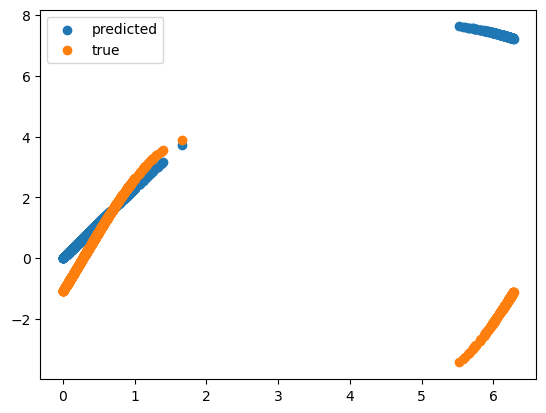

In [121]:

y_pred = model(x_data[:,0])
y_true = tf.math.cos(x_data[:,0]-x_data[:,1]) + tf.math.cos(x_data[:,0]-x_data[:,2])\
          + tf.math.cos(x_data[:,0]-x_data[:,3]) + tf.math.cos(x_data[:,0]-x_data[:,4])
plt.figure()
plt.scatter(x_data[:,0],y_pred,label="predicted")
plt.scatter(x_data[:,0],y_true,label="true")
plt.legend()
plt.show()


In [123]:
x_data[:,1:5]

array([[1.71909646, 1.68910831, 1.96929167, 2.02049597],
       [1.71909646, 1.68910831, 1.96929167, 2.02049597],
       [1.71909646, 1.68910831, 1.96929167, 2.02049597],
       ...,
       [1.71909646, 1.68910831, 1.96929167, 2.02049597],
       [1.71909646, 1.68910831, 1.96929167, 2.02049597],
       [1.71909646, 1.68910831, 1.96929167, 2.02049597]])

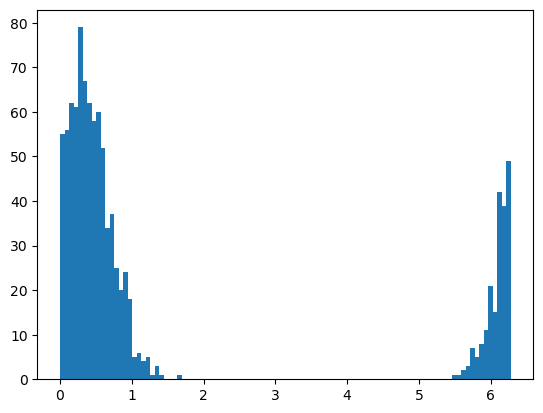

In [125]:
plt.hist(x_data[:,0],bins=100)
plt.show()

In [118]:
x_data[0]

array([0.41999012, 1.71909646, 1.68910831, 1.96929167, 2.02049597])

In [119]:
x_val_new[0]

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.48522625, 1.71909646, 1.68910831, 1.96929167, 2.02049597])>

In [83]:
## Extract formula: Method 1 #################################
kernels = []
biases = []
i = 0

for layer in model.layers:
  if i%2 == 1: #take only dense layers and not func layers
    k,b = layer.get_weights()
    kernels.append(k)
    biases.append(b)
  i = i+1

In [99]:
## Extract formula: Method 2 ###################################

kernels = []
biases = []
for i in range(len(d_layers)):
  k, b = d_layers[i].layer.get_weights()
  kernels.append(k)
  biases.append(b)

In [100]:
in_nodes = sympy.symbols([f'x_{j+1}' for j in range(input_dim)], real=True)

def symbolic_dense(in_expr, kernel, bias):
  out_expr = []
  for i in range(kernel.shape[1]):
    expr = bias[i] + sum([w*x for w,x in zip(kernel[:,i], in_expr)])
    out_expr.append(expr)
  return out_expr

#referred https://github.com/martius-lab/EQL_Tensorflow/blob/master/utils.py
def yield_with_repeats(iterable, repeats):
    """ Yield the ith item in iterable repeats[i] times. """
    it = iter(iterable)
    for num in repeats:
        new_val = next(it)
        for i in range(num):
            yield new_val

def yield_equal_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def iter_by_chunks(lst, chunk_lens):
    splits = [0] + list(accumulate(chunk_lens))
    for beg, end in zip(splits[:-1], splits[1:]):
        yield lst[beg:end]

def input_generator(in_expr):
  num_args = [1,1,1]
  repeats = [v,v,v]
  lengths = (a * b for a, b in zip(repeats, num_args))
  all_inputs = iter_by_chunks(in_expr, lengths)
  for big_input, arg in zip(all_inputs, repeats):
        yield from zip(*yield_equal_chunks(big_input, arg))

def symbolic_eql(in_expr):
  repeats = [v,v,v]
  fn_iter = yield_with_repeats(sympy_ops, repeats)
  inp_iter = input_generator(in_expr)
  expr = [fn(*item) for item,fn in zip(inp_iter, fn_iter)]
  return expr

In [101]:
res = in_nodes
for i in range(L-1): ##hidden layers
  res = symbolic_dense(res, kernels[i], biases[i])
  res = symbolic_eql(res)
final_expr = symbolic_dense(res, kernels[L-1], biases[L-1])

In [102]:
print(final_expr)

[2.48106932640076*sin(0.304651826620102*x_1) + 2.525958776474*sin(0.304651945829391*x_1) + 2.65786719322205*sin(0.304651975631714*x_1)]


In [103]:
print(in_nodes)

[x_1]


In [ ]:
# Evaluate
x_int_test = tf.random.uniform(shape=[1000,5],minval=-1,maxval=1,seed=10)
y_int_test = tf.math.cos(x_int_test[:,0]-x_int_test[:,1]) + tf.math.cos(x_int_test[:,0]-x_int_test[:,2]) \
          + tf.math.cos(x_int_test[:,0]-x_int_test[:,3]) + tf.math.cos(x_int_test[:,0]-x_int_test[:,4])

print(x_int_test.get_shape())
print(y_int_test.get_shape())

y_int_pred = model.predict(x_int_test)
print(y_int_test[:10].numpy())
print(y_int_pred[:10])

(1000, 5)
(1000,)
32/32 [==============================] - 0s 2ms/step
[2.6729279 3.6438878 1.9597814 3.423102  2.3374755 3.783485  3.7766137
 1.4907472 1.4525564 2.7729478]
[[2.6761672]
 [3.6461947]
 [1.956576 ]
 [3.4249556]
 [2.338623 ]
 [3.7857301]
 [3.7799225]
 [1.5004735]
 [1.4647846]
 [2.782048 ]]


AttributeError: ignored

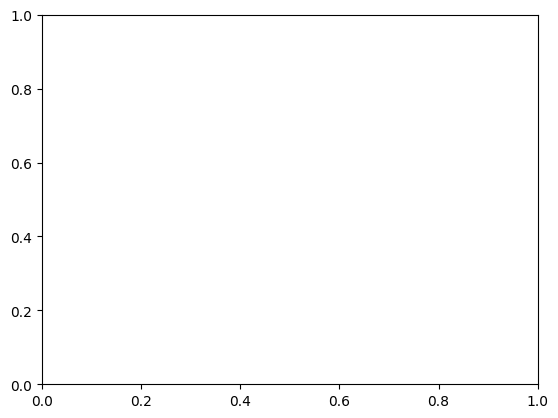

In [ ]:
plt.scatter(x_int_test[:,0],y_int_test,c='y',s=2, label = 'y_true')
plt.scatter(x_int_test[:,0],y_int_pred,c='k',s=1, label = 'y_pred')
plt.legend()
plt.show()

In [ ]:
# Extrapolation dataset
x_ext = tf.random.uniform(shape=[1000,1],minval=-2,maxval=2,seed=10)
mask = tf.cast(tf.abs(x_ext) > 1.0, dtype='tf.float32')
x_ext = tf.multiply(x_ext, mask)
y_ext_test = (1./3)*(tf.multiply(1.+x_ext,tf.sin(np.pi*x_ext)) +
                  tf.multiply(tf.multiply(x_ext,x_ext),x_ext))

print(x_ext.get_shape())

x_ext_test = tf.concat([x_ext]*4,axis=1)
print(x_ext_test.get_shape())

y_ext_pred = model(x_ext_test, 1e-4, 0, 0)
print(y_ext_pred.get_shape())

In [ ]:
plt.scatter(x_int_test[:,0],y_int_test,c='y',s=10, name = 'y_true')
plt.scatter(x_int_test[:,0],y_int_pred,c='k',s=1, name = 'y_pred')
plt.show()

In [ ]:
# Model Selection

In [ ]:
from tensorflow.keras.metrics import mean_squared_error

In [ ]:
def model_score(alpha = 0.5, beta = 0.5, gamma = 0.5, use_extrapolation = 0):
  errors = []
  val_int_error = mean_squared_error(y_int_test, y_int_pred)
  sparsity = None
  errors.append(val_int_error)
  errors.append(sparsity)

  if use_extrapolation == 1:
    beta = 0.0
    val_ext_error = mean_squared_error(y_ext_test, y_ext_pred)
    errors.append(val_ext_error)

  return errors

In [ ]:
function ConnectButton(){
  console.log("Connect pushed");
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);